### time-mean dQ2 target vs RF/NN-ens prediction maps 

In [1]:
import fv3viz
import xarray as xr
import fsspec
from dataclasses import dataclass
from typing import Sequence, Mapping
import os
from vcm.catalog import catalog as CATALOG
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
from cartopy import crs as ccrs

In [2]:
@dataclass
class MLOfflineDiags:
    name: str
    root: str
    model_variables: Mapping[str, Sequence[str]]
        
@dataclass
class Variable:
    name: str
    long_name: str
    units: str

In [3]:
dQ1 = Variable('column_integrated_dQ1', 'column-integrated heating (dQ1)', 'W/m^2')
dQ2 = Variable('column_integrated_dQ2', 'column-integrated moistening (dQ2)', 'mm/day')
dQu = Variable('column_integrated_dQu', 'column-integrated easterly wind tendency (dQu)', 'Pa')
dQv = Variable('column_integrated_dQv', 'column-integrated northerly wind tendency (dQv)', 'Pa')
downward_shortwave = Variable('override_for_time_adjusted_total_sky_downward_shortwave_flux_at_surface', 'downward shortwave', 'W/m^2')
downward_longwave = Variable('override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface', 'downward longwave', 'W/m^2')
net_shortwave = Variable('override_for_time_adjusted_total_sky_net_shortwave_flux_at_surface', 'net shortwave', 'W/m^2')

RUNS = [
    MLOfflineDiags(
        'RF',
        'gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/offline_diags',
        {
            'postphysics_ML_tendencies': [dQ1, dQ2, dQu, dQv],
            'prephysics_ML_surface_flux': [downward_shortwave, downward_longwave, net_shortwave]
        }
    ),
    MLOfflineDiags(
        'NN-ensemble',
         'gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags',
        {
            'dq1-dq2': [dQ1, dQ2],
            'dqu-dqv': [dQu, dQv],
            'surface-rad': [downward_shortwave, downward_longwave, net_shortwave]
        }
    )       
]

In [4]:
def open_diags(path):
    with fsspec.open(path, 'rb') as f:
        ds = xr.open_dataset(f).load()
    return ds

pred_datasets = []
target_ds = {}
for run in RUNS:
    run_pred_ds = {}
    for model in run.model_variables.keys():
        path = os.path.join(run.root, model, 'offline_diagnostics.nc')
        print(path)
        diags = open_diags(path)
        for variable in run.model_variables[model]:
            if variable.name not in target_ds:
                target_ds[variable.name] = (
                    diags[variable.name]
                    .sel(derivation='target')
                    .drop_vars('derivation')
                ).assign_attrs({
                'long_name': variable.long_name,
                'units': variable.units
            })
            # since rad variables have a huge spatial pattern show bias (pred - target)
            if "flux_at_surface" in variable.name:
                run_pred_ds[variable.name] = (
                    diags[variable.name]
                    .sel(derivation='predict')
                    .drop_vars('derivation')
                ) - target_ds[variable.name]
            else:
                run_pred_ds[variable.name] = (
                    diags[variable.name]
                    .sel(derivation='predict')
                    .drop_vars('derivation')
                ).assign_attrs({
                    'long_name': variable.long_name,
                    'units': variable.units
                })
    pred_datasets.append(xr.Dataset(run_pred_ds).expand_dims({'derivation': [run.name]}))
pred_ds = xr.concat(pred_datasets, dim='derivation')
target_ds = xr.Dataset(target_ds).expand_dims({'derivation': ['target']})
ds = xr.merge([target_ds, pred_ds])

gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/offline_diags/postphysics_ML_tendencies/offline_diagnostics.nc
gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/offline_diags/prephysics_ML_surface_flux/offline_diagnostics.nc
gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags/dq1-dq2/offline_diagnostics.nc
gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags/dqu-dqv/offline_diagnostics.nc
gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/offline_diags/surface-rad/offline_diagnostics.nc


In [5]:
grid = CATALOG['grid/c48'].to_dask()
MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}

/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
/home/brianh/miniconda3/envs/fv3net/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_l

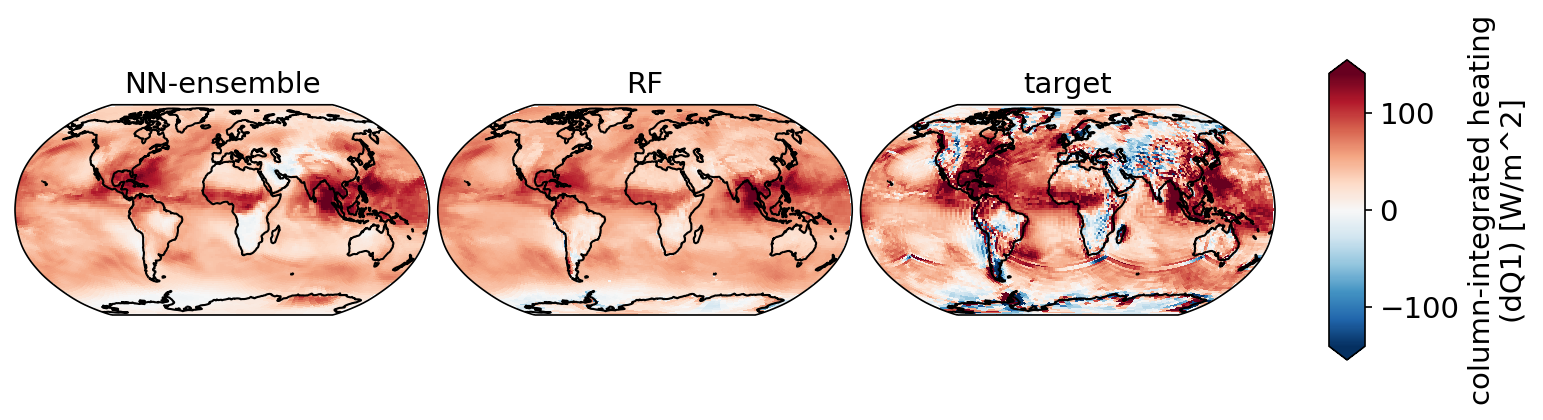

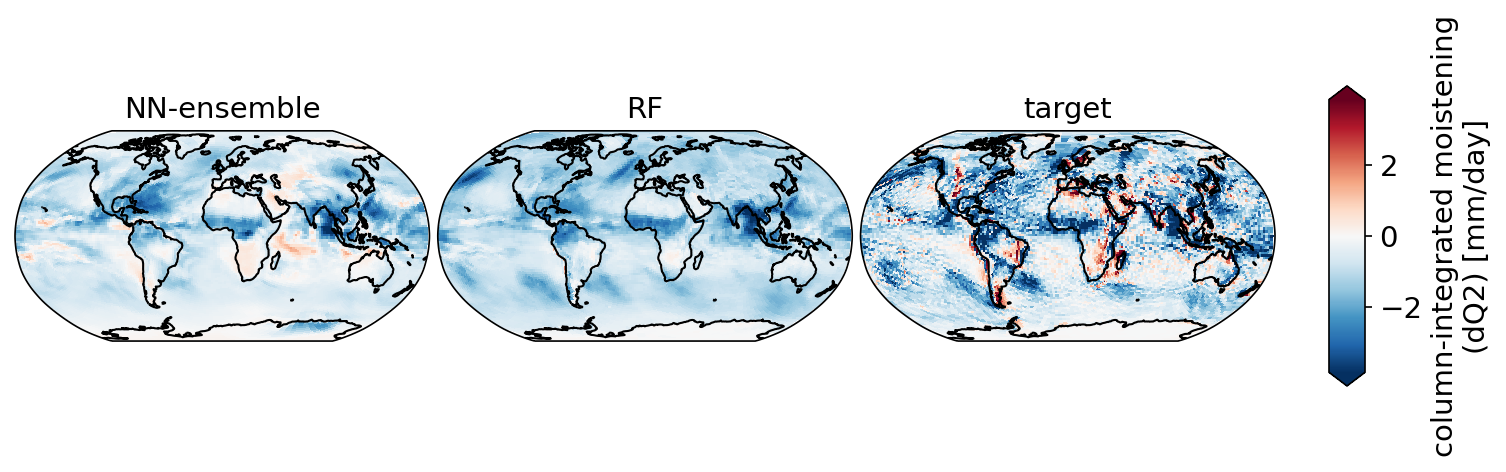

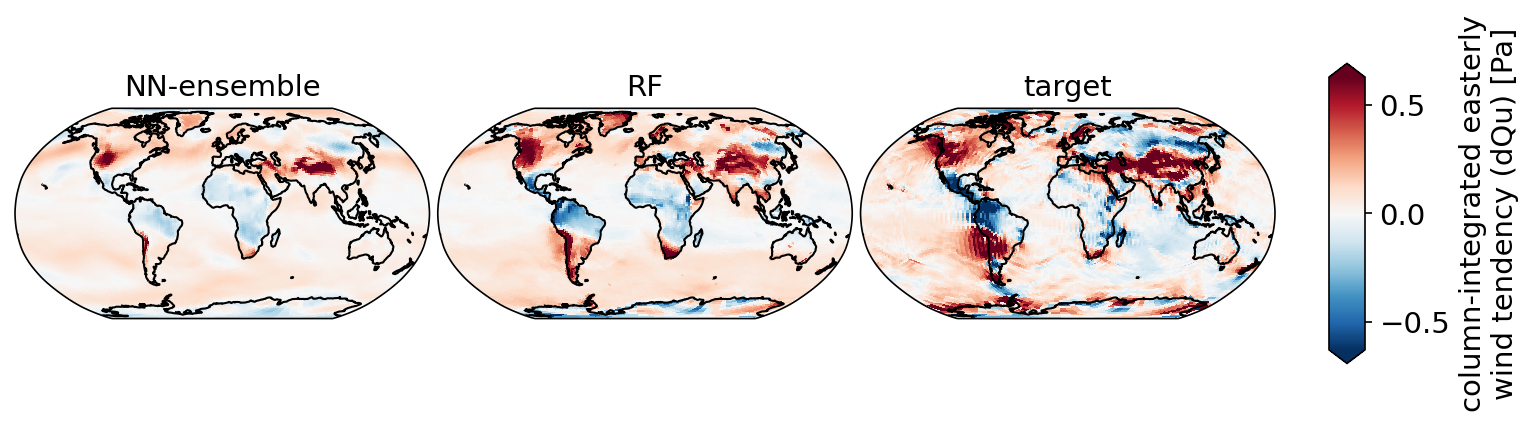

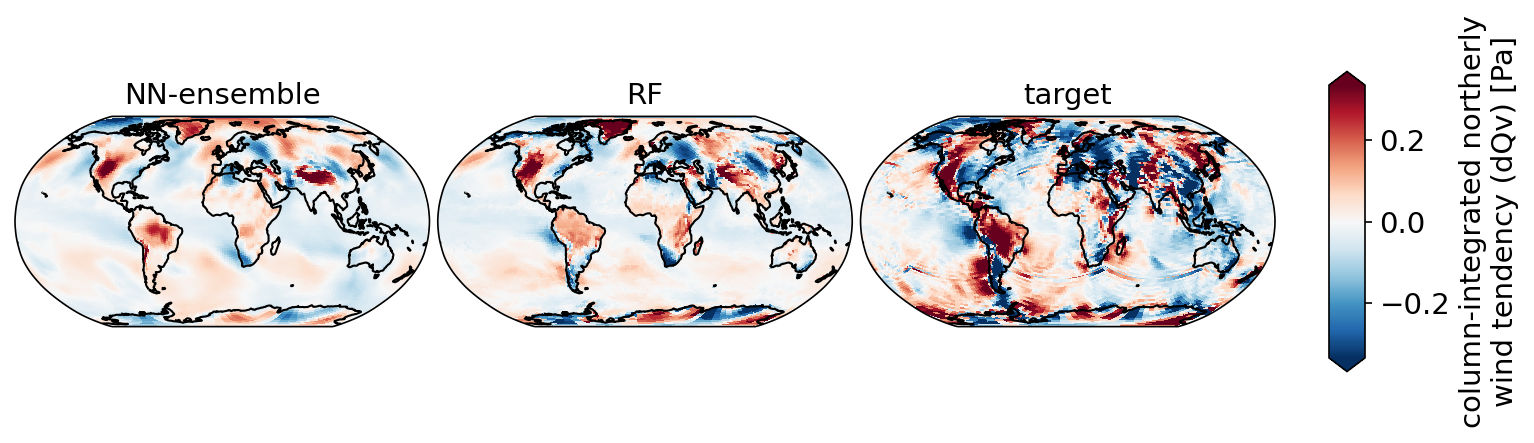

In [9]:
vars_2d = [
    'column_integrated_dQ1',
    'column_integrated_dQ2',
    'column_integrated_dQu',
    'column_integrated_dQv'
]

for var in vars_2d:
    _, _, _, _, fg = fv3viz.plot_cube(
        fv3viz.mappable_var(xr.merge([grid, ds]), var, **MAPPABLE_VAR_KWARGS),
        col = 'derivation'
    )
    fg.set_titles('{value}')
    fg.fig.set_size_inches([12, 2.5])
    fg.fig.set_dpi(150)
    fg.fig.savefig(f'{var}_offline_time_mean.png', bbox_inches='tight')

In [7]:
def plot_rad_maps(ds, var, abs_scale, bias_scale):
    fig, axes = plt.subplots(1, 3, subplot_kw={"projection": ccrs.Robinson()})
    h0 = fv3viz.plot_cube_axes(
        ds[var].sel(derivation='target').values,
        ds["lat"].values,
        ds["lon"].values,
        ds["latb"].values,
        ds["lonb"].values,
        "pcolormesh",
        ax=axes[0],
        **abs_scale
    )
    axes[0].set_title('target')
    axes[0].coastlines()
    plt.colorbar(h0, ax=axes[0], label=ds[var].attrs.get('long_name', '') + '\n[W/m^2]')
    h1 = fv3viz.plot_cube_axes(
        ds[var].sel(derivation='RF').values,
        ds["lat"].values,
        ds["lon"].values,
        ds["latb"].values,
        ds["lonb"].values,
        "pcolormesh",
        cmap="RdBu_r",
        ax=axes[1],
        **bias_scale
    )
    axes[1].set_title('RF')
    axes[1].coastlines()
    h2 = fv3viz.plot_cube_axes(
        ds[var].sel(derivation='NN-ensemble').values,
        ds["lat"].values,
        ds["lon"].values,
        ds["latb"].values,
        ds["lonb"].values,
        "pcolormesh",
        cmap="RdBu_r",
        ax=axes[2],
        **bias_scale
    )
    axes[2].set_title('NN-ensemble')
    axes[2].coastlines()
    plt.colorbar(h1, ax=axes[1:], label=ds[var].attrs.get('long_name', '') + ' bias \n[W/m^2]')
    fig.set_size_inches([14, 2.5])
    fig.set_dpi(150)
    fig.savefig(f'{var}_offline_time_mean.png', bbox_inches='tight')

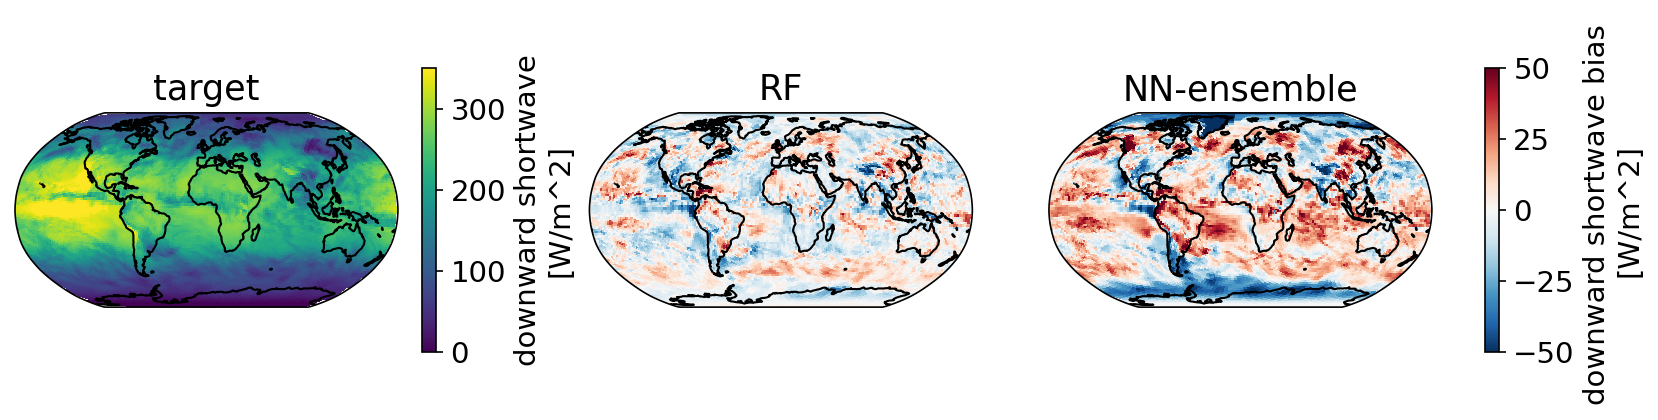

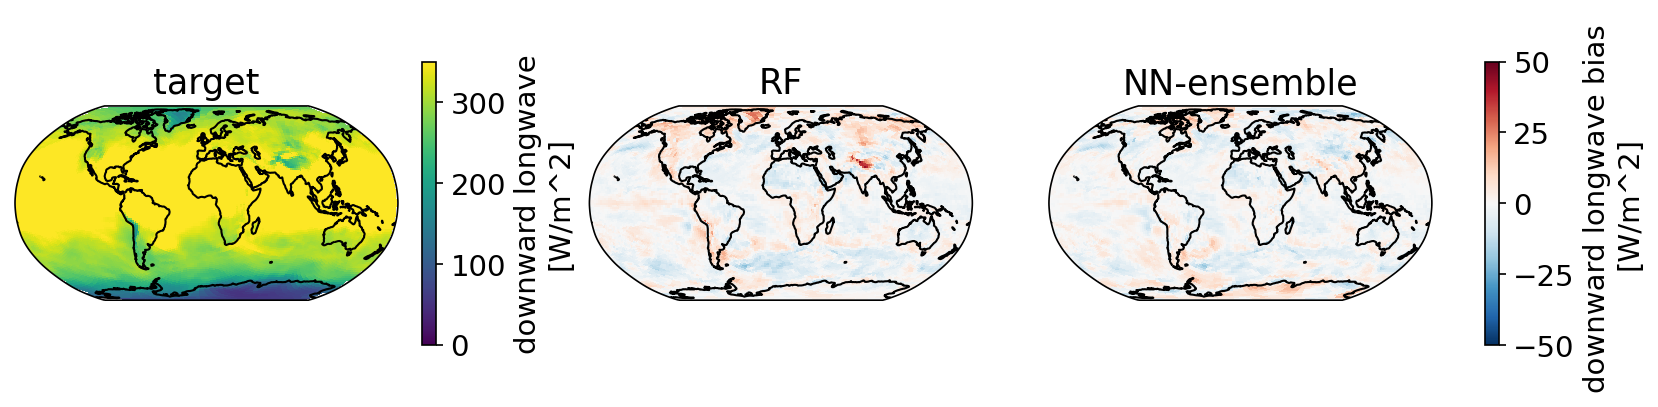

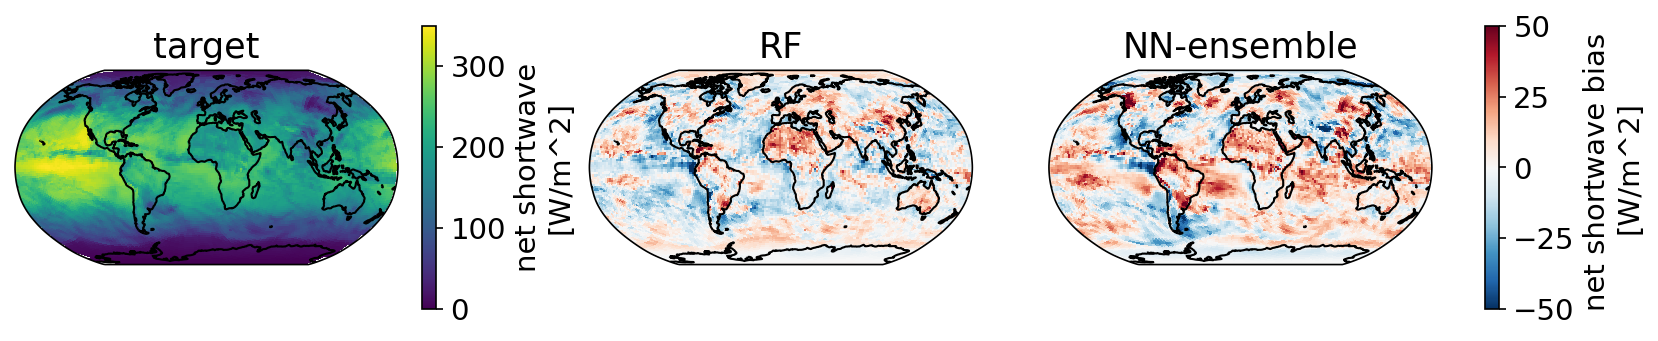

In [8]:
rad_vars = [
    'override_for_time_adjusted_total_sky_downward_shortwave_flux_at_surface',
    'override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface',
    'override_for_time_adjusted_total_sky_net_shortwave_flux_at_surface'
]
abs_scale = dict(vmin=0, vmax=350)
bias_scale = dict(vmin=-50, vmax=50)
for var in rad_vars:
    plot_rad_maps(fv3viz.mappable_var(xr.merge([grid, ds]), var, **MAPPABLE_VAR_KWARGS), var, abs_scale, bias_scale)